In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# imports

import os
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import random
import torch.optim as optim
import torch.tensor as tensor
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import  balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
files = np.load('/content/drive/MyDrive/resampled_train.npy')
train_files = [file[0] for file in files]
print(train_files)
print(len(train_files))

In [ ]:
train = [np.load('/content/drive/MyDrive/stft12020/train/' + file) for file in train_files]
print(len(train))

In [10]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,5,padding=2)

    self.fc1 = nn.Linear(57600,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,2)

    self.norm1 = nn.BatchNorm2d(1)

  def forward(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2)
    x = torch.flatten(x,start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x),dim=1)
    
    return x

  def feature_extraction(self,x):

    x = self.norm1(x)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2)
    x = torch.flatten(x,start_dim=1)

    return x.cpu().detach().numpy()

device = torch.device('cuda')

In [ ]:
# Train CNN and linear layers

batch_size = 32

train = np.array(train)
labels = np.array([int('preictal' in file) for file in train_files])

net = Net()
net = net.double()
# net.to(device)
    
optimizer = optim.Adam(net.parameters(),lr=1e-4, weight_decay=1e-2)

train_idx,valid_idx = train_test_split(np.arange(len(train)),test_size=0.2,random_state=0,stratify=labels)
train_size = len(train_idx)
batch_number = train_size//batch_size
epoch_count = 0

valid_size = len(valid_idx)
valid_batches = [valid_idx[i:i+batch_size] for i in range(0,valid_size-batch_size,batch_size)]
y_valid = labels[valid_idx]
y_valid = y_valid[:len(valid_batches)*32]

min_loss = 1000
loss_values = []
max_acc = 0
acc_values = []

stop1 = False
stop2 = False

while stop1 == False or stop2 == False:

    random.shuffle(train_idx)
    batches = [train_idx[i:i+batch_size] for i in range(0,train_size-batch_size,batch_size)]
    epoch_count += 1
    batch_count = 0

    for batch in batches:

        start = time.time()
        batch_count += 1
        # y = tensor(labels[batch]).to(device)
        y = tensor(labels[batch])
        n1 = torch.count_nonzero(y)
        n0 = batch_size-n1
        # x = tensor(train[batch]).to(device)
        x = tensor(train[batch])
        x = x.unsqueeze(1)

        net.zero_grad()
        output = net(x)
        # loss = F.nll_loss(output,y,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double().to(device))
        loss = F.nll_loss(output,y,weight=tensor([batch_size/(2*n0),batch_size/(2*n1)]).double())
        loss.backward()
        optimizer.step()
        print('Epoch number %d' % (epoch_count))
        print('Batch number %d/%d' % (batch_count,batch_number))
        print('Loss is %f' % (float(loss)))
        print(stop1,stop2)
        end = time.time()
        print(end-start)
        print('\n')

    with torch.no_grad():

        preds = []

        for batch in valid_batches:

            # x = tensor(train[batch]).to(device)
            x = tensor(train[batch])
            x = x.unsqueeze(1)

            preds.extend([int(i) for i in list(torch.argmax(net(x),dim=1))])

    if stop1 == False:

        loss = sum([abs(y_valid[i]-preds[i]) for i in range(len(preds))])/len(preds)
        loss_values.append(loss)

        if loss < min_loss:

            min_loss = loss
            #os.remove('/content/drive/MyDrive/D/final_model_loss.pt')
            torch.save(net.state_dict(),'/content/drive/MyDrive/D/final_model_loss.pt')
            count1 = 0

        else:

            count1 += 1

            if count1 == 10:

                stop1 = True

    if stop2 == False:

        acc = balanced_accuracy_score(y_valid,preds)
        acc_values.append(acc)

        if acc > max_acc:

            max_acc = acc
            #os.remove('/content/drive/MyDrive/D/final_model_acc.pt')
            torch.save(net.state_dict(),'/content/drive/MyDrive/D/final_model_acc.pt')
            count2 = 0

        else:

            count2 += 1

            if count2 == 10:

                stop2 = True

In [ ]:
while True:
  pass

[]

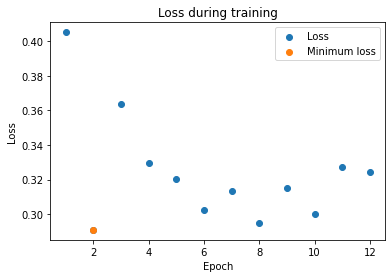

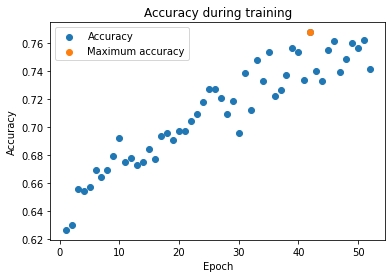

In [ ]:
epochs = np.arange(1,len(loss_values)+1)

plt.figure()
a=plt.scatter(epochs,loss_values)
b=plt.scatter(len(loss_values)-10,min_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend((a,b),('Loss','Minimum loss'))
plt.title('Loss during training')
plt.plot()

epochs = np.arange(1,len(acc_values)+1)

plt.figure()
a=plt.scatter(epochs,acc_values)
b=plt.scatter(len(acc_values)-10,max_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend((a,b),('Accuracy','Maximum accuracy'))
plt.title('Accuracy during training')
plt.plot()

In [ ]:
np.save('/content/drive/MyDrive/D/acc_save.npy',acc_values)

In [11]:
net = Net()
map_location=torch.device('cpu')
net.load_state_dict(torch.load('/content/drive/MyDrive/final_model_acc.pt'))

net = net.double()
net.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (norm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
# Train SVM or logistic regression

train = np.array(train)
labels = np.array([int('preictal' in file) for file in train_files])

train_idx,valid_idx = train_test_split(np.arange(len(train)),test_size=0.2,random_state=0,stratify=labels)

train_size = len(train_idx)
batch_size = 32

random.shuffle(train_idx)
batches = [train_idx[i:i+batch_size] for i in range(0,train_size-batch_size,batch_size)]

features = []
y = []
count = 0
for batch in batches:

    count += 1

    x = tensor(train[batch]).to(device)
    x = x.unsqueeze(1)

    features.extend(list(net.feature_extraction(x)))
    y.extend(list(labels[batch]))

    print(count)

features = np.array(features)
y = np.array(y)

In [ ]:
scaler = StandardScaler(copy=False)
scaler.fit(features)
scaler.transform(features)

In [ ]:
#logistic regression as classifier
from sklearn.linear_model import LogisticRegression

logistic =  LogisticRegression(class_weight='balanced',max_iter=1000,random_state=0)
logistic.fit(features,y)

In [ ]:
dir,_,filenames = next(os.walk('/content/drive/MyDrive/stft12020/test/'))
segments = list(set(['_'.join(file.split('_')[:5]) for file in filenames]))
print(segments)

In [ ]:
test_files = np.genfromtxt('/content/drive/MyDrive/dataset/SzPrediction_answer_key.csv', delimiter=',', skip_header=1, usecols=0, dtype='str')
test_labels = np.genfromtxt('/content/drive/MyDrive/dataset/SzPrediction_answer_key.csv', delimiter=',', skip_header=1, usecols=1, dtype='int')

labels = {test_files[i].split('.')[0]:test_labels[i] for i in range(len(test_labels))}
print(labels)

In [ ]:
from collections import Counter

print(Counter(labels.values()))

In [ ]:
# Predictions Neuro network

with torch.no_grad():

  y_pred1 = []
  y_true = []
  count = 0
  size = len(segments)
  total_preds = []
  total_labels = []

  for segment in segments:

    start = time.time()

    count += 1

    x = tensor([np.load(os.path.join(dir,file)) for file in filenames if segment in file]).to(device)
    x = x.unsqueeze(1)

    preds = [int(i) for i in list(torch.argmax(net(x),dim=1))]

    if preds.count(1) >= preds.count(0):

      y_pred1.append(1)

    else:

      y_pred1.append(0)

    label = labels[segment]
    y_true.append(label)
    total_preds.extend(preds)
    total_labels.extend([label]*len(preds))

    print('Segment %d/%d' % (count,size))
    print(time.time()-start)

Streaming output truncated to the last 5000 lines.
Segment 446/2945
5.037701368331909
Segment 447/2945
4.989994049072266
Segment 448/2945
4.801606893539429
Segment 449/2945
4.652469635009766
Segment 450/2945
4.728911399841309
Segment 451/2945
5.273890733718872
Segment 452/2945
4.5815393924713135
Segment 453/2945
4.76996922492981
Segment 454/2945
4.393177509307861
Segment 455/2945
3.3115196228027344
Segment 456/2945
4.812080383300781
Segment 457/2945
3.281071424484253
Segment 458/2945
4.028602838516235
Segment 459/2945
4.855214357376099
Segment 460/2945
4.168313026428223
Segment 461/2945
4.1969804763793945
Segment 462/2945
4.965207815170288
Segment 463/2945
4.829570293426514
Segment 464/2945
3.363954544067383
Segment 465/2945
4.383203983306885
Segment 466/2945
5.123434782028198
Segment 467/2945
4.6966612339019775
Segment 468/2945
4.674297571182251
Segment 469/2945
3.396636724472046
Segment 470/2945
4.358237266540527
Segment 471/2945
5.836764097213745
Segment 472/2945
4.8597564697265625


In [ ]:
# Predictions logistic regretion as classifier

y_pred2 = []
y_true = []
count = 0

for segment in segments:

  count += 1

  x = tensor([np.load(os.path.join(dir,file)) for file in filenames if segment in file]).to(device)

  x = x.unsqueeze(1)
  fts = scaler.transform(net.feature_extraction(x))
  preds = list(logistic.predict(fts))

  if preds.count(1) >= preds.count(0):

    y_pred2.append(1)

  else:

    y_pred2.append(0)

  y_true.append(labels[segment])

  print(count,len(segments))

In [ ]:
np.save('/content/drive/MyDrive/DACO/total_predslog.npy',total_preds)
np.save('/content/drive/MyDrive/DACO/total_labelslog.npy',total_labels)
np.save('/content/drive/MyDrive/DACO/y_predlog.npy',y_pred2)
np.save('/content/drive/MyDrive/DACO/y_truelog.npy',y_true)

In [ ]:
# Accuracy CNN

acc1 = balanced_accuracy_score(y_true,y_pred1)
acc1_preictal = sum([1 for i in range(len(y_pred1)) if y_pred1[i]==1 and y_true[i]==1])/y_true.count(1)
acc1_interictal = sum([1 for i in range(len(y_pred1)) if y_pred1[i]==0 and y_true[i]==0])/y_true.count(0)

test_acc = [acc1,acc1_preictal,acc1_interictal]
np.save('/content/drive/MyDrive/DACO/test_acc.npy',test_acc)

print(acc1)
print(acc1_preictal)
print(acc1_interictal)

0.5620739599845604
0.3865979381443299
0.737549981824791


In [ ]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_true, y_pred1)

print(cm)

[[2029  722]
 [ 119   75]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred1))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      2751
           1       0.09      0.39      0.15       194

    accuracy                           0.71      2945
   macro avg       0.52      0.56      0.49      2945
weighted avg       0.89      0.71      0.78      2945



In [23]:
# Accuracy Logistic Regression

acc2 = balanced_accuracy_score(y_true,y_pred2)
acc2_preictal = sum([1 for i in range(len(y_pred2)) if y_pred2[i]==1 and y_true[i]==1])/y_true.count(1)
acc2_interictal = sum([1 for i in range(len(y_pred2)) if y_pred2[i]==0 and y_true[i]==0])/y_true.count(0)

#test_acc = [acc2,acc2_preictal,acc2_interictal]
#np.save('/content/drive/MyDrive/DACO/test_acc_log.npy',test_acc)

print(acc2)
print(acc2_preictal)
print(acc2_interictal)

0.5437608001640161
0.3508771929824561
0.736644407345576


In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      2396
           1       0.09      0.35      0.14       171

    accuracy                           0.71      2567
   macro avg       0.51      0.54      0.48      2567
weighted avg       0.88      0.71      0.78      2567

